In [1]:
import os
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
from keras.callbacks import ModelCheckpoint
#from keras.applications.resnet50 import preprocess_input
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
#import resnet
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from classification_models import ResNet18
from classification_models.resnet import preprocess_input
from sklearn.utils import class_weight
import seaborn as sn

Using TensorFlow backend.


In [3]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
train_batchsize = 64
val_batchsize = 64
# train_dir = "D:/retinal_data_set_visioncare/TrainValidationData/augmented_train_data_224"
# validation_dir = "D:/retinal_data_set_visioncare/TrainValidationData/validation"
# test_dir = "D:/retinal_data_set_visioncare/newTrainValidationTestData/new_test"

train_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/train"
#validation_dir = "D:/retinal_data_set_visioncare/TrainValidationData/validation"
test_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/test"

model_check_point_loc = 'D:/retinal_data_set_visioncare/models/resnet18/resnet_updated_all_cnn_dr.h5'

#resnet_base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
#resnet_base = resnet.ResNet101(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
# resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
# # Freeze the layers except the last 2 layers
# for layer in resnet_base.layers[:]:
#     layer.trainable = False

# # Check the trainable status of the individual layers
# for layer in resnet_base.layers:
#     print(layer, layer.trainable)

In [87]:
# resnet_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_37[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

#validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=train_batchsize,
        shuffle=False,
        class_mode=None)

# validation_generator = validation_datagen.flow_from_directory(
#         validation_dir,
#         target_size=(image_width, image_height),
#         batch_size=train_batchsize,
#         class_mode='categorical',
#         shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=val_batchsize,
        class_mode=None,
        shuffle=False)

Found 741 images belonging to 5 classes.
Found 186 images belonging to 5 classes.


In [5]:
len(train_generator)

12

In [6]:
source = 'D:/retinal_data_set_visioncare/newTrainValidationTestData/new_valid/0/140_right.jpeg'
img = image.load_img(source, target_size=(224, 224))
x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)

In [7]:
x.shape

(224, 224, 3)

In [8]:
# image_list=[]
# labels=[]
# train_data_dir = 'D:/retinal_data_set_visioncare/original_new/'
# non_dr_root = train_data_dir + '0' + '/'
# non_dr_imgs = os.listdir(non_dr_root)

def generate_XY(train_data_dir, size=224):
    image_list=[]
    labels=[]
    
    non_dr_root = train_data_dir + '0' + '/'
    non_dr_imgs = os.listdir(non_dr_root)
    for non_dr in non_dr_imgs:
        if non_dr == 'Thumbs.db':
            continue
        img = image.load_img(source, target_size=(size, size))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        image_list.append(x)
        labels.append(0)

    mild_npdr_root = train_data_dir + '1' + '/'
    mild_npdr_imgs = os.listdir(mild_npdr_root)
    for mild_npdr in mild_npdr_imgs:
        if mild_npdr == 'Thumbs.db':
            continue
        img = image.load_img(source, target_size=(224, 224))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        image_list.append(x)
        labels.append(1)

    moderate_npdr_root = train_data_dir + '2' + '/'
    moderate_npdr_imgs = os.listdir(moderate_npdr_root)
    for moderate_npdr in moderate_npdr_imgs:
        if moderate_npdr == 'Thumbs.db':
            continue
        img = image.load_img(source, target_size=(224, 224))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        image_list.append(x)
        labels.append(2)

    severe_npdr_root = train_data_dir + '3' + '/'
    severe_npdr_imgs=os.listdir(severe_npdr_root)
    for severe_npdr in severe_npdr_imgs:
        if severe_npdr == 'Thumbs.db':
            continue
        img = image.load_img(source, target_size=(224, 224))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        image_list.append(x)
        labels.append(3)

    pdr_root = train_data_dir + '4' + '/'
    pdr_imgs=os.listdir(pdr_root)
    for pdr in pdr_imgs:
        if pdr == 'Thumbs.db':
            continue
        img = image.load_img(source, target_size=(224, 224))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        image_list.append(x)
        labels.append(4)
    
    return np.array(image_list), np.array(labels)

In [9]:
# x_train, y_train = zip(*(train_generator[i] for i in range(len(train_generator))))
# #x_train = np.vstack(x_train)
# #y_train = np_utils.to_categorical(train_generator.classes, 5)

# #x_test, y_test = zip(*(test_generator[i] for i in range(len(test_generator))))
train_directory = train_dir + '/'
test_directory = test_dir + '/'
X_train, y_train = generate_XY(train_directory)
X_test, y_test = generate_XY(test_directory)

y_train_onehot = to_categorical(y_train, 5)
y_test_onehot = to_categorical(y_test, 5)

In [10]:
# normalize inputs from 0-255 to 0-1
# X_train = X_train / 255
# X_test = X_test / 255

X_train = np.array(X_train) 
X_train = preprocess_input(X_train)

X_test = np.array(X_test) 
X_test = preprocess_input(X_test)

In [11]:
X_test.shape

(186, 224, 224, 3)

In [12]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [13]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [14]:
dict(enumerate(class_weight))

{0: 0.37236180904522614,
 1: 1.5278350515463917,
 2: 1.2453781512605042,
 3: 2.9058823529411764,
 4: 1.95}

In [15]:
class_weight_dic = dict(enumerate(class_weight))

In [16]:
X_train.shape[1:]

(224, 224, 3)

In [17]:
resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(X_train.shape[1:]))

# Freeze the layers except the last 2 layers
for layer in resnet_base.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in resnet_base.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x0000024DBEB7EF28> False
<keras.layers.normalization.BatchNormalization object at 0x0000024DB489D198> False
<keras.layers.convolutional.ZeroPadding2D object at 0x0000024DC5144630> False
<keras.layers.convolutional.Conv2D object at 0x0000024D800E5EB8> False
<keras.layers.normalization.BatchNormalization object at 0x0000024DC51442B0> False
<keras.layers.core.Activation object at 0x0000024D84797F28> False
<keras.layers.convolutional.ZeroPadding2D object at 0x0000024D847B88D0> False
<keras.layers.pooling.MaxPooling2D object at 0x0000024D847977B8> False
<keras.layers.normalization.BatchNormalization object at 0x0000024D8485D4A8> False
<keras.layers.core.Activation object at 0x0000024D84880FD0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x0000024D84880C50> False
<keras.layers.convolutional.Conv2D object at 0x0000024D84895278> False
<keras.layers.normalization.BatchNormalization object at 0x0000024D84C24908> False
<keras.layers.core.

In [19]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
#kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
#input_dim = 512
#input_dim = 350

# Create the model
# add a global spatial average pooling layer 28 , 28 , 128
x = resnet_base.get_layer(index=-1).output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2, name='global_avg_dropout')(x)
# add a fully-connected layer
# x = Dense(128, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01), use_bias=False)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5, name='fc1_dropout')(x)
# x = Dense(128, kernel_initializer=initializers.he_normal(seed=None), use_bias=False, kernel_regularizer=regularizers.l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5, name='fc2_dropout')(x)
# and a fully connected output/classification layer
#x = Dense(5, kernel_initializer=initializers.he_normal(seed=None))(x)
#x = Dense(5, activity_regularizer=regularizers.l2(0.001), use_bias=False)(x)
#kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)
x = Dense(5, kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l2(0.0001), use_bias=False)(x)
x = BatchNormalization()(x)
predictions = Activation('softmax')(x)
# create the full network so we can train on it
model = Model(inputs=resnet_base.input, outputs=predictions)
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [20]:
X = X_train
#X = transformed_data
Y = y_train

In [21]:
X.shape

(741, 224, 224, 3)

In [22]:
# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['acc'])

In [23]:
model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [25]:
# # Train the model
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch=train_generator.samples//train_generator.batch_size,
#       epochs=150,
#       callbacks=[model_checkpoint],
#       validation_data=validation_generator,
#       validation_steps=validation_generator.samples//validation_generator.batch_size,
#       verbose=1)
batch_size = 64
for train, test in kfold.split(X, Y):
    # Fit the model
    model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)

In [11]:
train_generator.samples

5000

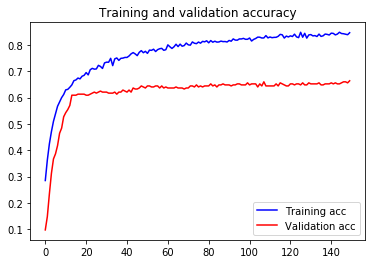

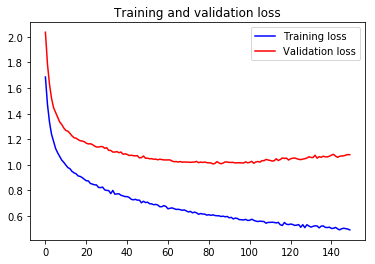

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [42]:
# Returns a compiled model identical to the previous one
loaded_model = load_model(model_check_point_loc)

In [43]:
#Confution Matrix and Classification Report
Y_pred = loaded_model.predict_generator(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[136   0  10   0   1]
 [ 33   0   4   0   0]
 [ 13   0  31   0   1]
 [  3   0  11   0   6]
 [  4   0   9   0  16]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.72      0.93      0.81       147
    mild-npdr       0.00      0.00      0.00        37
moderate-npdr       0.48      0.69      0.56        45
  severe-npdr       0.00      0.00      0.00        20
          pdr       0.67      0.55      0.60        29

  avg / total       0.53      0.66      0.58       278



c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4])

In [6]:
#Confution Matrix and Classification Report for testset
Y_pred_for_test = loaded_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
Y_pred_for_test = np.argmax(Y_pred_for_test, axis=1)
print('Confusion Matrix for testset')
print(confusion_matrix(test_generator.classes, Y_pred_for_test))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(test_generator.classes, Y_pred_for_test, target_names=target_names))

Confusion Matrix for testset
[[169  22   8   1   0]
 [ 25 167   3   5   0]
 [ 13  13 153  20   1]
 [  5   9  10 173   3]
 [  0   0   0   1 199]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.80      0.84      0.82       200
    mild-npdr       0.79      0.83      0.81       200
moderate-npdr       0.88      0.77      0.82       200
  severe-npdr       0.86      0.86      0.86       200
          pdr       0.98      0.99      0.99       200

  avg / total       0.86      0.86      0.86      1000



In [33]:
# generate roc curve
n_classes = 5

# Plot linewidth.
lw = 2

#convert original class labels to the one-hot-encoding
y_test = np_utils.to_categorical(test_generator.classes, 5)

Y_test_pred = loaded_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
Y_test_predicted = np.argmax(Y_test_pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [36]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

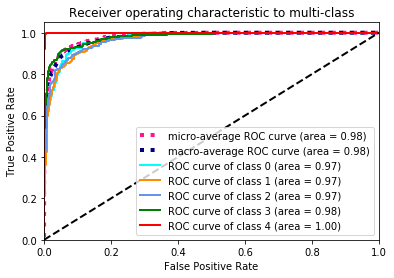

In [38]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

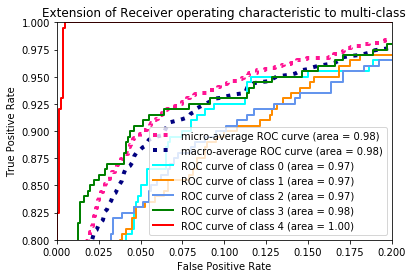

In [39]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()